In [1]:
import os 
from fog.code.utils.utils import *

# from fog.code.utils.utils import *
from pyspark.sql.functions import lit, col
from pyspark.sql.types import StringType, BooleanType, IntegerType, FloatType, DateType
from pyspark.sql import SparkSession
from google.cloud import storage

import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
    # measures how close each point in one cluster is to points in the neighboring clusters 
    #  helping in figuring out clusters that are compact and well-spaced out.

In [2]:
spark = SparkSession.builder.appName("K-Means Test").getOrCreate()

## Read in daily processed parquet files

In [3]:
daily_path = "parkinsons_data/unlabeled_combined/daily_one_day"
defog_path = "parkinsons_data/train/processed/defog_tasks"
top_bucket_name = "msca-bdp-student-gcs"

In [4]:
def feed_files(top_bucket_name, prefix, suffix):
    client = storage.Client()
    blobs = client.list_blobs(top_bucket_name, prefix=prefix)

    processed = None

    for i, blob in enumerate(blobs):
        print(blob.name)
        if blob.name.endswith(suffix):
            
            if suffix == ".parquet":
                df = spark.read.parquet(f"gs://{top_bucket_name}/{blob.name}")
            elif suffix == ".csv":
                df = spark.read.csv(f"gs://{top_bucket_name}/{blob.name}")
            if processed is None:
                processed = df
            else:
                processed = processed.union(df)
    return processed

In [5]:
def vectorize_features(dataframe, features):
    assemble=VectorAssembler(inputCols=features, outputCol = 'features')
    assembled_data = assemble.transform(dataframe)
    
    return assembled_data

In [6]:
def standardize_features(assembled_dataframe):
    scale = StandardScaler(inputCol='features', outputCol = 'standardized')
    data_scale = scale.fit(assembled_dataframe)
    data_scale_output = data_scale.transform(assembled_dataframe)
    
    return data_scale_output

In [7]:
defog_processed = feed_files(top_bucket_name, defog_path, ".parquet")
daily_processed = feed_files(top_bucket_name, daily_path, ".parquet")

parkinsons_data/train/processed/defog_tasks/
parkinsons_data/train/processed/defog_tasks/_SUCCESS
parkinsons_data/train/processed/defog_tasks/part-00000-6093110f-ab1f-4d32-8374-296135c35de0-c000.snappy.parquet


parkinsons_data/train/processed/defog_tasks/part-00001-6093110f-ab1f-4d32-8374-296135c35de0-c000.snappy.parquet
parkinsons_data/train/processed/defog_tasks/part-00002-6093110f-ab1f-4d32-8374-296135c35de0-c000.snappy.parquet
parkinsons_data/train/processed/defog_tasks/part-00003-6093110f-ab1f-4d32-8374-296135c35de0-c000.snappy.parquet
parkinsons_data/train/processed/defog_tasks/part-00004-6093110f-ab1f-4d32-8374-296135c35de0-c000.snappy.parquet


parkinsons_data/train/processed/defog_tasks/part-00005-6093110f-ab1f-4d32-8374-296135c35de0-c000.snappy.parquet
parkinsons_data/train/processed/defog_tasks/part-00006-6093110f-ab1f-4d32-8374-296135c35de0-c000.snappy.parquet
parkinsons_data/train/processed/defog_tasks/part-00007-6093110f-ab1f-4d32-8374-296135c35de0-c000.snappy.parquet
parkinsons_data/train/processed/defog_tasks/part-00008-6093110f-ab1f-4d32-8374-296135c35de0-c000.snappy.parquet
parkinsons_data/train/processed/defog_tasks/part-00009-6093110f-ab1f-4d32-8374-296135c35de0-c000.snappy.parquet
parkinsons_data/train/processed/defog_tasks/part-00010-6093110f-ab1f-4d32-8374-296135c35de0-c000.snappy.parquet
parkinsons_data/train/processed/defog_tasks_lagging/
parkinsons_data/unlabeled_combined/daily_one_day/
parkinsons_data/unlabeled_combined/daily_one_day/_SUCCESS
parkinsons_data/unlabeled_combined/daily_one_day/part-00000-26ba933d-cb86-4a7c-bca4-56cc7864f451-c000.snappy.parquet
parkinsons_data/unlabeled_combined/daily_one_day/p

In [9]:
print(defog_processed.columns)
print(daily_processed.columns)

['Subject', 'Visit', 'Id', 'Time', 'AccV', 'AccML', 'AccAP', 'StartHesitation', 'Turn', 'Walking', 'Valid', 'Task', 'SourceDefog', 'Medication', 'Age', 'Sex', 'YearsSinceDx', 'UPDRSIII_On', 'UPDRSIII_Off', 'NFOGQ', 'Test', 'TimeSeconds', 'Begin', 'End', 'TaskType', 'MB9', 'Rest1', 'MB6-L', 'MB6-R', 'Turning-C', 'MB2a', 'MB3-L', 'MB12', 'MB5', 'MB3-R', 'MB13', 'TUG-DT', 'Turning-ST', 'TUG-ST', '4MW-C', 'Hotspot2', 'MB6', 'TUG-C', '4MW', 'Hotspot1-C', 'Hotspot2-C', 'MB8', 'Hotspot1', 'MB4', 'MB1', 'MB7', 'Rest2', 'MB2b', 'MB10', 'Turning-DT', 'MB11', 'target']
['Subject', 'Id', 'Time', 'AccV', 'AccML', 'AccAP', 'Visit', 'record_begin', 'NFOGQ', 'TimeSeconds']


In [8]:
defog_processed = vectorize_features(defog_processed, ['AccV', 'AccML', 'AccAP'])
daily_processed = vectorize_features(daily_processed, ['AccV', 'AccML', 'AccAP'])

defog_processed = standardize_features(defog_processed)
daily_processed = standardize_features(daily_processed)

### Use the Silhouette Score to determine ideal number of clusters
https://www.data4v.com/tutorial-k-means-clustering-on-spark/

In [ ]:
# THIS TAKES VERY LONG TO RUN, the highest silhouette score is at index 67 if you just need the number
silhouette_score = []
evaluator = ClusteringEvaluator(predictionCol = 'prediction', \
                                featuresCol = 'standardized', \
                                metricName = 'silhouette', \
                                distanceMeasure = 'squaredEuclidean')

for i in range(2,100):
    kmeans = KMeans(featuresCol = 'standardized', k = i)
    kmeans_fit = kmeans.fit(data_scale_output)
    output = kmeans_fit.transform(data_scale_output)
    
    evaluation_score = evaluator.evaluate(output)
    silhouette_score.append(evaluation_score)
    if i % 20 == 0:
        print(i)

max_score = max(silhouette_score)
print("max score index", silhouette_score.index(max_score), max_score)
    

23/05/19 20:29:14 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/05/19 20:29:15 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


20


23/05/19 20:39:48 ERROR org.apache.spark.scheduler.AsyncEventQueue: Dropping event from queue dataprocEvent. This likely means one of the listeners is too slow and cannot keep up with the rate at which tasks are being started by the scheduler.
23/05/19 20:39:48 WARN org.apache.spark.scheduler.AsyncEventQueue: Dropped 1 events from dataprocEvent since the application started.


40


23/05/19 20:40:48 WARN org.apache.spark.scheduler.AsyncEventQueue: Dropped 922 events from dataprocEvent since Fri May 19 20:39:48 UTC 2023.
23/05/19 20:41:55 WARN org.apache.spark.scheduler.AsyncEventQueue: Dropped 1024 events from dataprocEvent since Fri May 19 20:40:48 UTC 2023.
23/05/19 20:43:03 WARN org.apache.spark.scheduler.AsyncEventQueue: Dropped 1056 events from dataprocEvent since Fri May 19 20:41:55 UTC 2023.
23/05/19 20:44:09 WARN org.apache.spark.scheduler.AsyncEventQueue: Dropped 1056 events from dataprocEvent since Fri May 19 20:43:03 UTC 2023.
23/05/19 20:45:12 WARN org.apache.spark.scheduler.AsyncEventQueue: Dropped 1056 events from dataprocEvent since Fri May 19 20:44:09 UTC 2023.


60


23/05/19 20:46:21 WARN org.apache.spark.scheduler.AsyncEventQueue: Dropped 1056 events from dataprocEvent since Fri May 19 20:45:12 UTC 2023.
23/05/19 20:47:29 WARN org.apache.spark.scheduler.AsyncEventQueue: Dropped 1056 events from dataprocEvent since Fri May 19 20:46:21 UTC 2023.
23/05/19 20:48:36 WARN org.apache.spark.scheduler.AsyncEventQueue: Dropped 1056 events from dataprocEvent since Fri May 19 20:47:29 UTC 2023.
23/05/19 20:49:44 WARN org.apache.spark.scheduler.AsyncEventQueue: Dropped 1056 events from dataprocEvent since Fri May 19 20:48:36 UTC 2023.
23/05/19 20:50:49 WARN org.apache.spark.scheduler.AsyncEventQueue: Dropped 1056 events from dataprocEvent since Fri May 19 20:49:44 UTC 2023.


80


23/05/19 20:51:56 WARN org.apache.spark.scheduler.AsyncEventQueue: Dropped 1056 events from dataprocEvent since Fri May 19 20:50:49 UTC 2023.
23/05/19 20:53:04 WARN org.apache.spark.scheduler.AsyncEventQueue: Dropped 1056 events from dataprocEvent since Fri May 19 20:51:56 UTC 2023.
23/05/19 20:54:11 WARN org.apache.spark.scheduler.AsyncEventQueue: Dropped 1056 events from dataprocEvent since Fri May 19 20:53:04 UTC 2023.
23/05/19 20:55:20 WARN org.apache.spark.scheduler.AsyncEventQueue: Dropped 1056 events from dataprocEvent since Fri May 19 20:54:11 UTC 2023.
23/05/19 20:56:26 WARN org.apache.spark.scheduler.AsyncEventQueue: Dropped 1056 events from dataprocEvent since Fri May 19 20:55:20 UTC 2023.


max score index 67 0.8337750758336424


Text(0, 0.5, 'Silhouette Score')

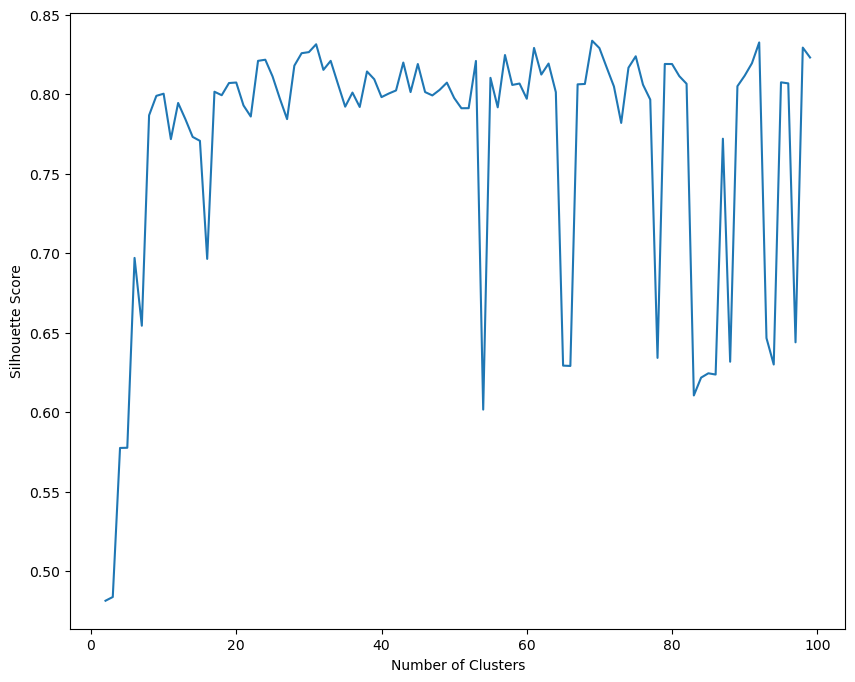

In [9]:
fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.plot(range(2,100), silhouette_score)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

### Add features to Defog with 67 clusters

In [ ]:
groups = 67
kmeans = KMeans(featuresCol = 'standardized', k = groups, seed = 1)
model = kmeans.fit(daily_processed.select('standardized'))
transformed = model.transform(defog_processed)
transformed = transformed.withColumn("prediction_67", transformed.prediction).drop("prediction")
transformed.select("Subject", "Id", "Time", "standardized", "prediction67").show(5)

23/05/20 23:31:56 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/05/20 23:31:56 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


+-------+----------+----+--------------------+----------+
|Subject|        Id|Time|        standardized|prediction|
+-------+----------+----+--------------------+----------+
| accced|a2f1a8ab76|   0|[-11.555618077760...|        61|
| accced|a2f1a8ab76|   1|[-11.522774455915...|        61|
| accced|a2f1a8ab76|   2|[-11.533671773512...|        61|
| accced|a2f1a8ab76|   3|[-11.499965923488...|        61|
| accced|a2f1a8ab76|   4|[-11.499902208635...|        61|
+-------+----------+----+--------------------+----------+
only showing top 5 rows



In [19]:
transformed.groupBy("prediction_67").count().show()

+-------------+-----+
|prediction_67|count|
+-------------+-----+
|           31|   16|
|           65|   27|
|           34|   12|
|           28|   13|
|           27|   33|
|           26|    5|
|           44| 5963|
|           12|   45|
|           22|   36|
|           47|   43|
|            1|   25|
|           13|    4|
|            6|   20|
|           16|    3|
|            3|  242|
|           20|   57|
|           40|   14|
|           57|    3|
|           54|   77|
|           48|  137|
+-------------+-----+
only showing top 20 rows



## Add features to Defog with 4 clusters

In [12]:
groups = 4
kmeans = KMeans(featuresCol = 'standardized', k = groups, seed = 1)
model = kmeans.fit(daily_processed.select('standardized'))
transformed4 = model.transform(transformed)
#transformed4.select("Subject", "Id", "Time", "standardized", "prediction").show(5)
transformed4 = transformed4.withColumn("prediction4", transformed4.prediction).drop("prediction")

In [16]:
#transformed4.select("prediction").distinct().show()
transformed4.groupBy("prediction4").count().show()

+-----------+--------+
|prediction4|   count|
+-----------+--------+
|          1|13521432|
|          3|    1079|
|          2|    2943|
|          0|     249|
+-----------+--------+



## Add in lagging values as features
Add in 'AccV', 'AccML', 'AccAP' values to defog as new features for past 10 timesteps, partitioned by person

In [13]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag 

features = ['AccV','AccML','AccAP']

for feat in features:
    for i in range(1,11):
        windowSpec = Window.partitionBy("Subject").orderBy("Time")
        transformed4 = transformed4.withColumn("{}_lag{}".format(feat,i),lag(feat, i).over(windowSpec))
    transformed4.select("Subject", "{}_lag{}".format(feat,i),feat,"prediction4").show(3)

+-------+----------+-----------+-----------+
|Subject|AccV_lag10|       AccV|prediction4|
+-------+----------+-----------+-----------+
| 5bfae2|      null| -0.8983334|          1|
| 5bfae2|      null|-0.90572405|          1|
| 5bfae2|      null| -0.8972374|          1|
+-------+----------+-----------+-----------+
only showing top 3 rows



+-------+-----------+-----------+-----------+
|Subject|AccML_lag10|      AccML|prediction4|
+-------+-----------+-----------+-----------+
| 5bfae2|       null|-0.14672334|          1|
| 5bfae2|       null|-0.13500977|          1|
| 5bfae2|       null|-0.14654109|          1|
+-------+-----------+-----------+-----------+
only showing top 3 rows



+-------+-----------+----------+-----------+
|Subject|AccAP_lag10|     AccAP|prediction4|
+-------+-----------+----------+-----------+
| 5bfae2|       null|0.42330447|          1|
| 5bfae2|       null|  0.406467|          1|
| 5bfae2|       null| 0.4230957|          1|
+-------+-----------+----------+-----------+
only showing top 3 rows



In [15]:
# Sanity check for lagged features
transformed4.select('AccML','AccAP','AccML_lag1','AccAP_lag1','AccML_lag2','AccAP_lag2','AccML_lag10','AccAP_lag10').show(20)

+-------------+------------+-------------+------------+-------------+------------+-------------+-----------+
|        AccML|       AccAP|   AccML_lag1|  AccAP_lag1|   AccML_lag2|  AccAP_lag2|  AccML_lag10|AccAP_lag10|
+-------------+------------+-------------+------------+-------------+------------+-------------+-----------+
|  -0.03657596|   0.4044014|         null|        null|         null|        null|         null|       null|
|  -0.03500191|   0.3973637|  -0.03657596|   0.4044014|         null|        null|         null|       null|
| -0.029427469|  0.38947272|  -0.03500191|   0.3973637|  -0.03657596|   0.4044014|         null|       null|
| -0.037811324|   0.4040465| -0.029427469|  0.38947272|  -0.03500191|   0.3973637|         null|       null|
|  -0.03285201|  0.40247783| -0.037811324|   0.4040465| -0.029427469|  0.38947272|         null|       null|
| -0.034468517|   0.4151124|  -0.03285201|  0.40247783| -0.037811324|   0.4040465|         null|       null|
|   0.11424488| -0.

In [14]:
transformed4.write.format("parquet").mode("overwrite").save("gs://msca-bdp-student-gcs/parkinsons_data/train/processed/defog_tasks_lagging")


23/05/20 23:49:36 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
